#### Erstellung des Datensatzes

Der Datensatz wird durch Aufnahmen der eigenen Hand erstellt. Hierbei wurden insgesamt 200 Bilder mithilfe einer Webcam aufgenommen, die später auch für das Spiel getestet werden. Die Daten werden außerdem durch Augmentation-Techniken erweitert. Dabei wird jedes Bild um zusätzliche 250 Bilder erweitert, wobei folgende Augmentation-Methoden angewandt werden:

* Drehung
* Anpassung von Helligkeit und Kontrast
* Skalierung und Verschiebung
* Hinzufügen von Rauschen
* Horizontale Spiegelung

Schließlich werden all diese Bilder in einem Ordner zusammengeführt.

In [74]:
import cv2
import os
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Erhalte letzte Bildnummer im Verzeichnis
def get_last_image_index(save_directory):
    image_files = [f for f in os.listdir(save_directory) if os.path.isfile(os.path.join(save_directory, f))]
    if not image_files:
        return 0

    indexes = [int(f.split('.')[0]) for f in image_files]
    return max(indexes)

# Überprüfe, ob das Bild schwarz ist
def is_black_image(frame, threshold=30):
    # Berechne die durchschnittliche Helligkeit des Bildes
    avg_brightness = int(frame.mean())

    # Wenn die durchschnittliche Helligkeit unter dem Schwellenwert liegt, ist das Bild größtenteils schwarz
    return avg_brightness < threshold

# Bilder speichern
def capture_images(camera_index, num_images, save_directory):
    # Öffne die hintere Kamera
    cap = cv2.VideoCapture(camera_index)

    if not cap.isOpened():
        print("Kamera konnte nicht geöffnet werden.")
        return

    # Erstelle das Verzeichnis, falls es nicht existiert
    os.makedirs(save_directory, exist_ok=True)

    # Wir lesen das erste Bild ohne es zu speichern
    _, _ = cap.read()

    last_index = get_last_image_index(save_directory)
    start_index = last_index + 1

    for i in range(start_index - 1, start_index + num_images - 1):
        # Bilder aufnehmen
        ret, frame = cap.read()
        if not ret:
            print("Fehler beim Erfassen des Bildes.")
            break

        # Bild anzeigen
        cv2.imshow(f"Bild {i}", frame)

        # Warte 1 Sekunde zwischen den Bildern
        cv2.waitKey(1000)

        # Überprüfe, ob das Bild schwarz ist
        if not is_black_image(frame):
            # Bild speichern
            file_name = os.path.join(save_directory, f"{i}.jpg")
            cv2.imwrite(file_name, frame)

    # Kamera freigeben und alle Fenster schließen
    cap.release()
    cv2.destroyAllWindows()

In [3]:
# Initialisierung der Variablen für die Datensammlung
camera_index = 0  # 0 für die Vorderkamera, 1 für die Rückkamera (falls vorhanden)
num_images = 101  # Anzahl der Bilder, die aufgenommen werden sollen (ignoriert erstes Bild)
save_directory = "./new_dataset/img"

In [6]:
# Speicherung der offenen Hand in verschiedenen Positionen
capture_images(camera_index, num_images, save_directory)

In [4]:
# Speicherung der geschlossenen Hand in verschiedenen Positionen
capture_images(camera_index, num_images, save_directory)

#### Augmentation

In [5]:
def flip_images(input_folder, output_folder, num_augmentations_per_image=1, num_random_images=50):
    # Erstelle den Ausgabeordner, falls er nicht existiert
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste aller Dateien im Eingabeordner
    image_files = os.listdir(input_folder)

    # Zufällige Bilder auswählen
    random_images = random.sample(image_files, min(num_random_images, len(image_files)))

    for image_file in random_images:
        input_path = os.path.join(input_folder, image_file)
        output_prefix, ext = os.path.splitext(image_file)

        # Lade das Bild
        image = cv2.imread(input_path)

        # Horizontales Spiegeln (Horizontal Flip)
        for i in range(num_augmentations_per_image):
            augmented_image = cv2.flip(image, 1)  # 1 für horizontales Spiegeln
            output_file = f"{output_prefix}_aug_{i+1}{ext}"
            output_path = os.path.join(output_folder, output_file)
            cv2.imwrite(output_path, augmented_image)


In [6]:
input_folder = "dataset/img"
output_folder = "dataset/aug"
num_augmentations_per_image = 1
num_random_images = 50

flip_images(input_folder, output_folder, num_augmentations_per_image, num_random_images)

In [7]:
def augment_rotation(image, angle_range=(-15, 15)):
    angle = random.uniform(angle_range[0], angle_range[1])
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def augment_brightness_contrast(image, brightness_range=(-30, 30), contrast_range=(0.5, 1.5)):
    brightness = random.uniform(brightness_range[0], brightness_range[1])
    contrast = random.uniform(contrast_range[0], contrast_range[1])
    return np.clip(image * contrast + brightness, 0, 255).astype(int)

def augment_scaling_translation(image, scale_range=(0.8, 1.2), translation_range=(-20, 20)):
    rows, cols = image.shape[:2]
    scale_factor = random.uniform(scale_range[0], scale_range[1])
    scaled_image = cv2.resize(image, (int(cols * scale_factor), int(rows * scale_factor)))
    
    translation_x = random.randint(translation_range[0], translation_range[1])
    translation_y = random.randint(translation_range[0], translation_range[1])
    
    M = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    return cv2.warpAffine(scaled_image, M, (cols, rows))

def augment_noise(image, mean=0, stddev=10):
    noise = np.random.normal(mean, stddev, image.shape).astype(int)
    return np.clip(image + noise, 0, 255).astype(int)


def augment_images(input_folder, output_folder, num_augmentations_per_image=1, num_random_images=50):
    # Erstelle den Ausgabeordner, falls er nicht existiert
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Liste aller Dateien im Eingabeordner
    image_files = os.listdir(input_folder)

    # Zufällige Bilder auswählen
    random_images = random.sample(image_files, min(num_random_images, len(image_files)))

    # Index für die Benennung der Bilder
    index = 1

    for image_file in random_images:
        input_path = os.path.join(input_folder, image_file)
        output_prefix, ext = os.path.splitext(image_file)

        # Lade das Bild
        image = cv2.imread(input_path)

        # Generiere 50 Bilder für jede Augmentation-Funktion
        for i in range(num_augmentations_per_image):
            augmented_image = cv2.flip(image, 1)  # 1 für horizontales Spiegeln
            output_file = f"{output_folder}/{index}.jpg"
            cv2.imwrite(output_file, augmented_image)
            index += 1

            augmented_image = augment_rotation(image)
            output_file = f"{output_folder}/{index}.jpg"
            cv2.imwrite(output_file, augmented_image)
            index += 1

            augmented_image = augment_brightness_contrast(image)
            output_file = f"{output_folder}/{index}.jpg"
            cv2.imwrite(output_file, augmented_image)
            index += 1

            augmented_image = augment_scaling_translation(image)
            output_file = f"{output_folder}/{index}.jpg"
            cv2.imwrite(output_file, augmented_image)
            index += 1

            augmented_image = augment_noise(image)
            output_file = f"{output_folder}/{index}.jpg"
            cv2.imwrite(output_file, augmented_image)
            index += 1

In [8]:
input_folder = "dataset/img"
output_folder = "dataset/aug"
num_augmentations_per_image = 1
num_random_images = 50

augment_images(input_folder, output_folder, num_augmentations_per_image, num_random_images)

Zusammenführung der beiden Ordner

In [9]:
def merge_and_rename_folders(folder1_path, folder2_path, destination_folder_path):
    # Ensure the destination folder exists
    os.makedirs(destination_folder_path, exist_ok=True)

    # Counter for the new file names
    counter = 1

    # Iterate through the first folder and copy the images
    for file in os.listdir(folder1_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            source = os.path.join(folder1_path, file)
            target = os.path.join(destination_folder_path, f'{counter}.jpg')
            shutil.copy(source, target)
            counter += 1

    # Iterate through the second folder and copy the images
    for file in os.listdir(folder2_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            source = os.path.join(folder2_path, file)
            target = os.path.join(destination_folder_path, f'{counter}.jpg')
            shutil.copy(source, target)
            counter += 1

    print("Merging and renaming completed.")


In [11]:
# Paths to the two folders with images
folder1_path = 'dataset/aug'
folder2_path = 'dataset/img'
destination_folder_path = 'dataset/img_merged'

# Call the function with the provided folder paths
merge_and_rename_folders(folder1_path, folder2_path, destination_folder_path)

Merging and renaming completed.


# Labels setzten 
Die Labels werden mittels makesense.ai erstellt. Hierbei werden die Bounding-Boxes manuell erstellt und das Ergebnis ist unten dargestellt.

In [72]:
# Funktion zum Lesen von YOLO-Labels aus einem Pfad
def read_yolo_labels(label_path):
    with open(label_path, 'r') as f:
        line = f.readline()
    return list(map(float, line.strip().split()))

# Funktion zur Darstellung von Bildern mit zugehörigen Beschriftungen
def show_images_with_labels(image_folder, label_folder, num_images=5, index_shift_range=(0, 450)):
    # Liste der Dateinamen in den Ordnern abrufen und sortieren
    image_files = sorted(os.listdir(image_folder))
    label_files = sorted(os.listdir(label_folder))

    # Größe des Figure-Fensters festlegen
    plt.figure(figsize=(15, 10))

    # Schleife über die ausgewählte Anzahl von Bildern
    for i in range(num_images):
        # Zufälligen Indexversatz innerhalb des Bereichs hinzufügen
        index_shift = random.randint(index_shift_range[0], index_shift_range[1])
        
        image_file = image_files[index_shift]
        image_path = os.path.join(image_folder, image_file)
        label_file = label_files[index_shift] 
        label_path = os.path.join(label_folder, label_file)

        # Bild einlesen und zugehörige Labels laden
        image = plt.imread(image_path)
        labels = read_yolo_labels(label_path)

        # Subplot für das aktuelle Bild erstellen
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)

        # Labels auswerten und Bounding Box zeichnen
        class_index, x, y, width, height = labels
        x1 = (x - width/2) * image.shape[1]
        y1 = (y - height/2) * image.shape[0]
        rect = patches.Rectangle((x1, y1), width*image.shape[1], height*image.shape[0], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        # Klassenname basierend auf dem Klassenindex bestimmen
        class_name = "Open_Hand" if class_index == 0 else "Fist"
        plt.text(x1, y1 - 5, class_name, color='red')

        # Titel und Achsen deaktivieren
        plt.title(f'Bild {i+1}')
        plt.axis('off')

    # Layout anpassen und Darstellung anzeigen
    plt.tight_layout()
    plt.show()


### Darstellung der Bilder mit zugehörigen Labels

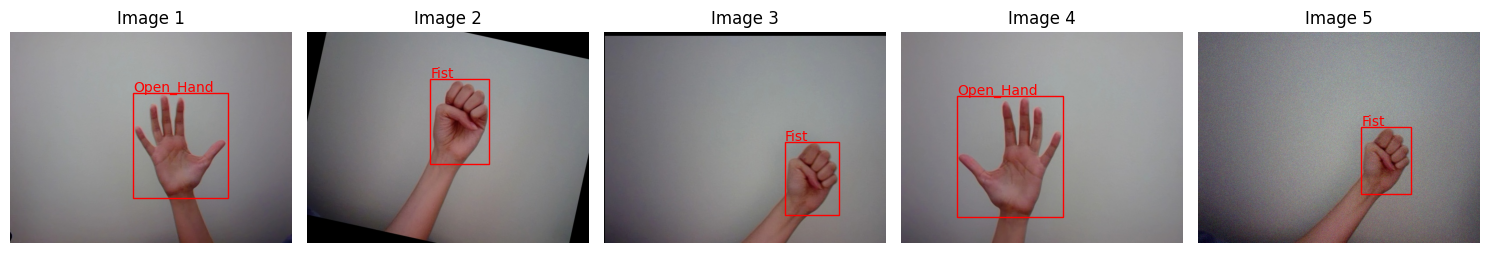

In [15]:
# Pfade zu den Ordnern für Bilder und Labels
image_folder = 'dataset/img_merged'
label_folder = 'dataset/labels'

# Anzahl der Bilder, die angezeigt werden sollen
num_images_to_show = 5

# Funktion aufrufen, um Bilder mit Labels anzuzeigen
show_images_with_labels(image_folder, label_folder, num_images_to_show)

#### Erweiterung des Datensatzes
Der Datensatz wird um zusätzliche 500 selbst generierte Bilder erweitert. Diese neuen Bilder enthalten sowohl einen Hintergrund als auch eine Person, da das YOLOv5-Modell den Kopf einer Person manchmal als Faust interpretiert. Die Erweiterung umfasst 100 Bilder von geöffneten Händen (Open_Hand) und 100 Bilder von Fäusten (Fist). Zusätzlich wurden 300 Bilder durch Augmentationstechniken erzeugt. Anschließend werden diese Bilder gelabelt (makesense.ai) und in den bestehenden Datensatz integriert.

In [61]:
# Definieren Sie die Pfade zu Ihren Ordnern
first_image_folder = "dataset/img_merged"
second_image_folder = "new_dataset/img_merged"
first_labels_folder = "dataset/labels"
second_labels_folder = "new_dataset/labels"
output_folder = "final"

# Erstellen Sie den Ausgabeordner und die Unterverzeichnisse, wenn sie nicht existieren
os.makedirs(os.path.join(output_folder, "img"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "labels"), exist_ok=True)

# Kopieren Sie den Inhalt des ersten Bild-Ordners in den Ausgabeordner
for filename in os.listdir(first_image_folder):
    shutil.copy(os.path.join(first_image_folder, filename), os.path.join(output_folder, "img", filename))

# Kopieren Sie den Inhalt des ersten Labels-Ordners in den Ausgabeordner
for filename in os.listdir(first_labels_folder):
    shutil.copy(os.path.join(first_labels_folder, filename), os.path.join(output_folder, "labels", filename))

# Bestimmen Sie den Dateinamen des letzten Bildes im Ausgabeordner
output_image_files = os.listdir(os.path.join(output_folder, "img"))
last_output_image_filename = max(output_image_files, key=lambda x: int(x.split('.')[0]))

# Ermitteln Sie die Nummer des letzten Bildes im Ausgabeordner
last_output_image_number = int(last_output_image_filename.split('.')[0])

# Sortieren Sie die Dateien im zweiten Bild-Ordner nach ihrer Nummerierung
second_image_files = sorted(os.listdir(second_image_folder), key=lambda x: int(x.split('.')[0]))

# Kopieren Sie die Bilder aus dem zweiten Ordner und passen Sie die Nummerierung an
for i, second_image_file in enumerate(second_image_files):
    new_image_number = last_output_image_number + i + 1
    new_image_filename = f"{new_image_number}.jpg"
    shutil.copy(os.path.join(second_image_folder, second_image_file), os.path.join(output_folder, "img", new_image_filename))

# Sortieren Sie die Dateien im zweiten Labels-Ordner nach ihrer Nummerierung
second_labels_files = sorted(os.listdir(second_labels_folder), key=lambda x: int(x.split('.')[0]))

# Kopieren Sie die Labels aus dem zweiten Ordner und passen Sie die Nummerierung an
for i, second_labels_file in enumerate(second_labels_files):
    new_labels_number = last_output_image_number + i + 1
    new_labels_filename = f"{new_labels_number}.txt"
    shutil.copy(os.path.join(second_labels_folder, second_labels_file), os.path.join(output_folder, "labels", new_labels_filename))

print("Bilder und Labels wurden erfolgreich zusammengeführt, die Reihenfolge wurde beibehalten, und die Nummerierung wurde fortgesetzt.")


Bilder und Labels wurden erfolgreich zusammengeführt, die Reihenfolge wurde beibehalten, und die Nummerierung wurde fortgesetzt.


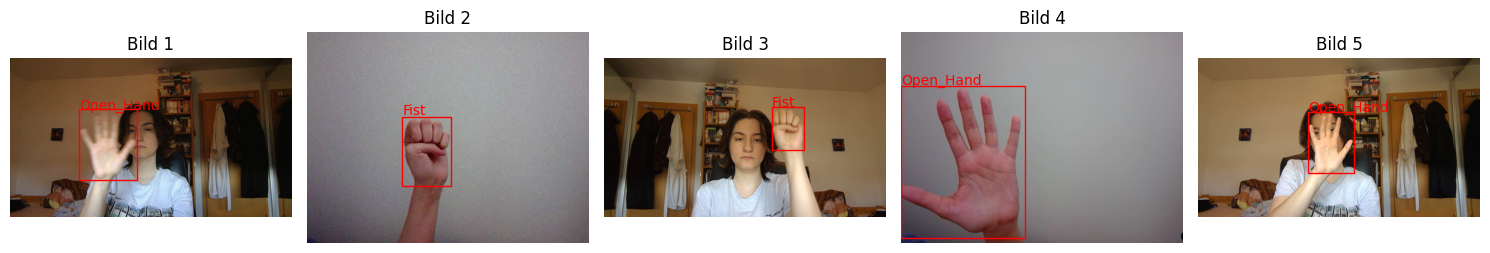

In [73]:
# Pfade zu den Ordnern für Bilder und Labels
image_folder = 'final/img'
label_folder = 'final/labels'

# Anzahl der Bilder, die angezeigt werden sollen
num_images_to_show = 5

# Funktion aufrufen, um Bilder mit Labels anzuzeigen
show_images_with_labels(image_folder, label_folder, num_images_to_show, index_shift_range=(0, 950))